In [153]:
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
import scipy as sp
import scipy.spatial
import sys

In [106]:
eps = sys.float_info.epsilon

n_towers = 200
xtower = 2.*np.random.rand(n_towers,1)
ytower = 2.*np.random.rand(n_towers,1)

towers = np.hstack([xtower,ytower])
bounding_box = np.array([0., 2., 0., 2.]) # [x_min, x_max, y_min, y_max]

def in_box(towers, bounding_box):
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0],
                                         towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1],
                                         towers[:, 1] <= bounding_box[3]))

In [107]:
def voronoi(towers, bounding_box):
    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)
    # Mirror points
    points_center = towers[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)
    # Compute Voronoi
    vor = sp.spatial.Voronoi(points)
    # Filter regions
    regions = []
    for region in vor.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if not(bounding_box[0] - eps <= x and x <= bounding_box[1] + eps and
                       bounding_box[2] - eps <= y and y <= bounding_box[3] + eps):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    vor.filtered_points = points_center
    vor.filtered_regions = regions
    return vor

In [108]:
def centroid_region(vertices):
    # Polygon's signed area
    A = 0
    # Centroid's x
    C_x = 0
    # Centroid's y
    C_y = 0
    for i in range(0, len(vertices) - 1):
        s = (vertices[i, 0] * vertices[i + 1, 1] - vertices[i + 1, 0] * vertices[i, 1])
        A = A + s
        C_x = C_x + (vertices[i, 0] + vertices[i + 1, 0]) * s
        C_y = C_y + (vertices[i, 1] + vertices[i + 1, 1]) * s
    A = 0.5 * A
    C_x = (1.0 / (6.0 * A)) * C_x
    C_y = (1.0 / (6.0 * A)) * C_y
    return np.array([[C_x, C_y]])

(-0.1, 1.1)

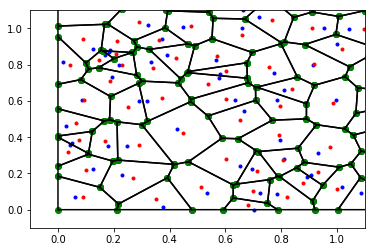

In [109]:
vor = voronoi(towers, bounding_box)

fig = pl.figure()
ax = fig.gca()
# Plot initial points
ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], 'b.')
# Plot ridges points
for region in vor.filtered_regions:
    vertices = vor.vertices[region, :]
    ax.plot(vertices[:, 0], vertices[:, 1], 'go')
# Plot ridges
for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]
    ax.plot(vertices[:, 0], vertices[:, 1], 'k-')
# Compute and plot centroids
centroids = []
for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]
    centroid = centroid_region(vertices)
    centroids.append(list(centroid[0, :]))
    ax.plot(centroid[:, 0], centroid[:, 1], 'r.')

ax.set_xlim([-0.1, 1.1])
ax.set_ylim([-0.1, 1.1])

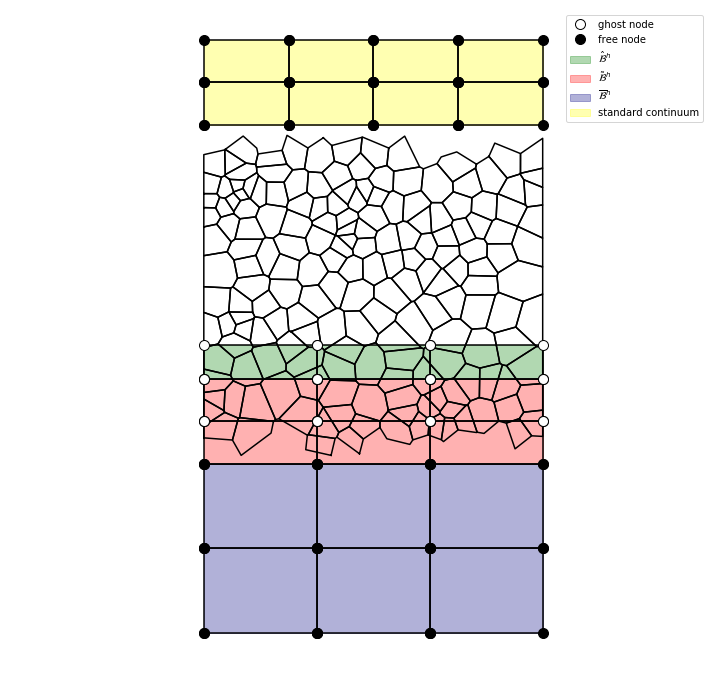

In [155]:
DNS_y_bounds = [0.0,2.0]
vor = voronoi(np.array(centroids), bounding_box)

fig = pl.figure(figsize=(12,12))
ax = fig.gca()
ax.axis('equal')
# Plot initial points
#ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], 'b.')
# Plot ridges points
#for region in vor.filtered_regions:
#    vertices = vor.vertices[region, :]
#    ax.plot(vertices[:, 0], vertices[:, 1], 'go')
# Plot ridges
for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]
    if all([not [np.isclose(DNS_y_bounds[0],y) or np.isclose(DNS_y_bounds[1],y)][0] for x,y in vertices]):
        ax.plot(vertices[:, 0], vertices[:, 1], 'k-')

def plot_mesh(x,y,ax,marker='o',marker_color='k',mesh_color='k',mesh_fill='b',mesh_fill_alpha=1.0,marker_fillstyle='k',s=10):
    X,Y = np.meshgrid(x,y)
    
    for i in range(len(y)-1):
        for j in range(len(x)-1):
            X_verts = [X[i,j],X[i+1,j],X[i+1,j+1],X[i,j+1],X[i,j]]
            Y_verts = [Y[i,j],Y[i+1,j],Y[i+1,j+1],Y[i,j+1],Y[i,j]]
            
            V = zip(X_verts,Y_verts)
            
            #ax.scatter(*zip(*V),marker=marker,color=marker_color)
            ax.fill(X_verts,Y_verts,color=mesh_fill,alpha=mesh_fill_alpha)
            #ax.plot(*zip(*V),color=mesh_color)
            ax.plot(X_verts,Y_verts,color=mesh_color,marker=marker,markeredgecolor=marker_color,markerfacecolor=marker_fillstyle,markersize=s)
        
    return mpatches.Patch(color=mesh_fill,alpha=mesh_fill_alpha),mlines.Line2D([], [], markeredgecolor=marker_color, markerfacecolor=marker_fillstyle, marker=marker, linestyle='None',
                          markersize=10, label='Blue stars')
        
#Plot the fully overlapped mesh
npts_x = 4
x_full_overlap_micro = np.linspace(bounding_box[0],bounding_box[1],npts_x)
y_full_overlap_micro = np.linspace(DNS_y_bounds[0]+0.5,0.7,2)

full_fh,full_mh = plot_mesh(x_full_overlap_micro,y_full_overlap_micro,ax,mesh_fill='green',marker_color='k',marker_fillstyle='white',mesh_fill_alpha=0.3)

#Plot the intermediate mesh
x_partial_overlap_micro = np.linspace(bounding_box[0],bounding_box[1],npts_x)
y_partial_overlap_micro = np.linspace(0.,DNS_y_bounds[0]+0.5,3)
partial_fh,partial_mh = plot_mesh(x_partial_overlap_micro,y_partial_overlap_micro,ax,mesh_fill='red',marker_color='k',marker_fillstyle='white',mesh_fill_alpha=0.3)
    
# Plot the free Micromorphic Mesh
x_free_micro = np.linspace(bounding_box[0],bounding_box[1],npts_x)
y_free_micro = np.linspace(-1.0,0.,3)

free_fh,free_mh = plot_mesh(x_free_micro,y_free_micro,ax,mesh_fill='navy',mesh_fill_alpha=0.3)
            
# Plot the incoming contact surface
x_incoming = np.linspace(bounding_box[0],bounding_box[1],5)
y_incoming = np.linspace(2.0,2.5,3)
incoming_fh,incoming_mh = plot_mesh(x_incoming,y_incoming,ax,mesh_fill='yellow',mesh_fill_alpha=0.3)

pl.axis('off')
pl.legend((full_mh,free_mh,full_fh,partial_fh,free_fh,incoming_fh),\
          ('ghost node','free node',r'$\hat{\mathcal{B}}^h$',r'$\tilde{\mathcal{B}}^h$',r'$\overline{\mathcal{B}}^h$','standard continuum'))
pl.savefig('overlapping_domains.pdf')
## Compute and plot centroids
#centroids = []
#for region in vor.filtered_regions:
#    vertices = vor.vertices[region + [region[0]], :]
#    centroid = centroid_region(vertices)
#    centroids.append(list(centroid[0, :]))
#    ax.plot(centroid[:, 0], centroid[:, 1], 'r.')

In [31]:
DNS_y_bounds = [0.,2.]
all([not [np.isclose(DNS_y_bounds[0],y) or np.isclose(DNS_y_bounds[1],y)][0] for x,y in vertices])

True

In [36]:
towers.shape

(100, 2)